# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 2


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [2]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [3]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [4]:
Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            # test 3 
            self.fc1 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            ## test 3
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [10]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 5.0 Training loss: 1.0352 Explore P: 0.9995
Episode: 2 Total reward: 18.0 Training loss: 1.0144 Explore P: 0.9977
Episode: 3 Total reward: 21.0 Training loss: 1.0118 Explore P: 0.9957
Episode: 4 Total reward: 13.0 Training loss: 1.0192 Explore P: 0.9944
Episode: 5 Total reward: 25.0 Training loss: 0.9847 Explore P: 0.9919
Episode: 6 Total reward: 8.0 Training loss: 1.0502 Explore P: 0.9911
Episode: 7 Total reward: 25.0 Training loss: 1.0430 Explore P: 0.9887
Episode: 8 Total reward: 13.0 Training loss: 1.1295 Explore P: 0.9874
Episode: 9 Total reward: 20.0 Training loss: 1.1354 Explore P: 0.9855
Episode: 10 Total reward: 11.0 Training loss: 1.0569 Explore P: 0.9844
Episode: 11 Total reward: 18.0 Training loss: 1.1511 Explore P: 0.9826
Episode: 12 Total reward: 54.0 Training loss: 1.5734 Explore P: 0.9774
Episode: 13 Total reward: 32.0 Training loss: 1.8072 Explore P: 0.9743
Episode: 14 Total reward: 12.0 Training loss: 1.4906 Explore P: 0.9731
Episode: 15 Total

Episode: 120 Total reward: 22.0 Training loss: 2.1656 Explore P: 0.7928
Episode: 121 Total reward: 12.0 Training loss: 69.6242 Explore P: 0.7919
Episode: 122 Total reward: 9.0 Training loss: 76.1269 Explore P: 0.7912
Episode: 123 Total reward: 9.0 Training loss: 2.1171 Explore P: 0.7905
Episode: 124 Total reward: 13.0 Training loss: 64.7962 Explore P: 0.7895
Episode: 125 Total reward: 8.0 Training loss: 97.3209 Explore P: 0.7888
Episode: 126 Total reward: 32.0 Training loss: 52.6425 Explore P: 0.7864
Episode: 127 Total reward: 8.0 Training loss: 32.9164 Explore P: 0.7857
Episode: 128 Total reward: 10.0 Training loss: 136.9724 Explore P: 0.7850
Episode: 129 Total reward: 25.0 Training loss: 6.2942 Explore P: 0.7830
Episode: 130 Total reward: 31.0 Training loss: 54.2019 Explore P: 0.7806
Episode: 131 Total reward: 16.0 Training loss: 52.6661 Explore P: 0.7794
Episode: 132 Total reward: 17.0 Training loss: 27.7895 Explore P: 0.7781
Episode: 133 Total reward: 24.0 Training loss: 5.5627 Exp

Episode: 233 Total reward: 64.0 Training loss: 26.8595 Explore P: 0.6365
Episode: 234 Total reward: 30.0 Training loss: 4.7301 Explore P: 0.6347
Episode: 235 Total reward: 22.0 Training loss: 22.7045 Explore P: 0.6333
Episode: 236 Total reward: 17.0 Training loss: 11.0681 Explore P: 0.6322
Episode: 237 Total reward: 21.0 Training loss: 73.2695 Explore P: 0.6309
Episode: 238 Total reward: 13.0 Training loss: 12.5549 Explore P: 0.6301
Episode: 239 Total reward: 13.0 Training loss: 29.1362 Explore P: 0.6293
Episode: 240 Total reward: 47.0 Training loss: 15.9618 Explore P: 0.6264
Episode: 241 Total reward: 13.0 Training loss: 4.0618 Explore P: 0.6256
Episode: 242 Total reward: 17.0 Training loss: 54.6467 Explore P: 0.6246
Episode: 243 Total reward: 29.0 Training loss: 35.9522 Explore P: 0.6228
Episode: 244 Total reward: 46.0 Training loss: 3.1713 Explore P: 0.6200
Episode: 245 Total reward: 44.0 Training loss: 30.5541 Explore P: 0.6173
Episode: 246 Total reward: 33.0 Training loss: 34.9669

Episode: 350 Total reward: 129.0 Training loss: 4.6608 Explore P: 0.2621
Episode: 351 Total reward: 89.0 Training loss: 464.5029 Explore P: 0.2599
Episode: 352 Total reward: 166.0 Training loss: 2.5829 Explore P: 0.2557
Episode: 353 Total reward: 155.0 Training loss: 318.4753 Explore P: 0.2520
Episode: 354 Total reward: 116.0 Training loss: 258.3864 Explore P: 0.2492
Episode: 355 Total reward: 184.0 Training loss: 4.0256 Explore P: 0.2448
Episode: 356 Total reward: 175.0 Training loss: 5.1406 Explore P: 0.2407
Episode: 357 Total reward: 121.0 Training loss: 2.9597 Explore P: 0.2380
Episode: 358 Total reward: 83.0 Training loss: 2.3460 Explore P: 0.2361
Episode: 359 Total reward: 99.0 Training loss: 76.2553 Explore P: 0.2339
Episode: 360 Total reward: 110.0 Training loss: 9.3019 Explore P: 0.2314
Episode: 361 Total reward: 136.0 Training loss: 9.5803 Explore P: 0.2284
Episode: 363 Total reward: 76.0 Training loss: 194.0465 Explore P: 0.2225
Episode: 364 Total reward: 89.0 Training loss:

Episode: 534 Total reward: 126.0 Training loss: 0.0091 Explore P: 0.0301
Episode: 536 Total reward: 152.0 Training loss: 0.0351 Explore P: 0.0294
Episode: 539 Total reward: 26.0 Training loss: 0.0664 Explore P: 0.0286
Episode: 542 Total reward: 84.0 Training loss: 0.0535 Explore P: 0.0277
Episode: 544 Total reward: 143.0 Training loss: 0.0167 Explore P: 0.0271
Episode: 547 Total reward: 17.0 Training loss: 0.0319 Explore P: 0.0264
Episode: 549 Total reward: 186.0 Training loss: 0.0192 Explore P: 0.0258
Episode: 551 Total reward: 188.0 Training loss: 0.0170 Explore P: 0.0252
Episode: 554 Total reward: 38.0 Training loss: 0.0177 Explore P: 0.0246
Episode: 557 Total reward: 99.0 Training loss: 0.0718 Explore P: 0.0239
Episode: 559 Total reward: 198.0 Training loss: 0.0423 Explore P: 0.0233
Episode: 562 Total reward: 99.0 Training loss: 0.0422 Explore P: 0.0227
Episode: 565 Total reward: 99.0 Training loss: 0.0426 Explore P: 0.0221
Episode: 567 Total reward: 187.0 Training loss: 0.0396 Exp

Episode: 707 Total reward: 15.0 Training loss: 21.6240 Explore P: 0.0134
Episode: 710 Total reward: 92.0 Training loss: 2.7213 Explore P: 0.0132
Episode: 713 Total reward: 99.0 Training loss: 9.9041 Explore P: 0.0131
Episode: 716 Total reward: 99.0 Training loss: 4.6839 Explore P: 0.0129
Episode: 719 Total reward: 99.0 Training loss: 2.8846 Explore P: 0.0128
Episode: 722 Total reward: 99.0 Training loss: 2.6391 Explore P: 0.0126
Episode: 725 Total reward: 99.0 Training loss: 4.2798 Explore P: 0.0125
Episode: 728 Total reward: 56.0 Training loss: 1.2999 Explore P: 0.0124
Episode: 731 Total reward: 57.0 Training loss: 0.8049 Explore P: 0.0123
Episode: 734 Total reward: 19.0 Training loss: 0.9767 Explore P: 0.0122
Episode: 737 Total reward: 79.0 Training loss: 0.3901 Explore P: 0.0121
Episode: 740 Total reward: 99.0 Training loss: 0.2307 Explore P: 0.0120
Episode: 743 Total reward: 99.0 Training loss: 0.4039 Explore P: 0.0119
Episode: 746 Total reward: 81.0 Training loss: 0.3598 Explore P

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

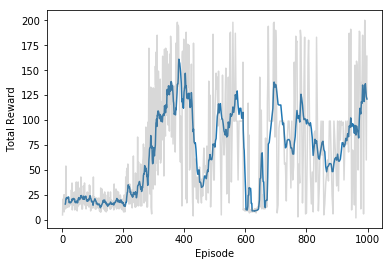

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [14]:
Text(0,0.5,'Total Reward')




NameError: name 'Text' is not defined

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.